In [1]:
# Import dependencies
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [2]:
# Read data
presnap_data_oline_all = pd.read_csv('https://storage.googleapis.com/big-data-bowl/presnap-data-oline-all.csv')
presnap_data_oline_encoded = pd.read_csv('https://storage.googleapis.com/big-data-bowl/presnap-data-oline-encoded.csv')

red_zone_line_player_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneLinePlayerProximity.csv')
red_zone_qb_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneQBProximity.csv')
players = pd.read_csv('https://storage.googleapis.com/big-data-bowl/players.csv')

week1 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week1.csv')
week2 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week2.csv')
week3 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week3.csv')
week4 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week4.csv')
week5 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week5.csv')
week6 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week6.csv')
week7 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week7.csv')
week8 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week8.csv')

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Clean and concatenate week data
week1['week'] = 1
week2['week'] = 2
week3['week'] = 3
week4['week'] = 4
week5['week'] = 5
week6['week'] = 6
week7['week'] = 7
week8['week'] = 8

tracking = week1.append([
    week2,
    week3,
    week4,
    week5,
    week6,
    week7,
    week8,
])

In [4]:
# Define matchup threshold
matchup_distance_threshold = 1
matchup_duration_threshold = 30

In [5]:
# Get unique matchups that fall below threshold for frames exceeding the matchup duration_threshold
red_zone_line_player_matchups = red_zone_line_player_proximity[red_zone_line_player_proximity['distance'] <= matchup_distance_threshold]
unique_matchups = red_zone_line_player_matchups[['gameId', 'playId', 'nflId', 'nflId2', 'frameId']].groupby(['gameId', 'playId', 'nflId', 'nflId2']).min().reset_index()

In [6]:
# Initialize confirmed matchups DataFrame
confirmed_matchups = pd.DataFrame()

In [7]:
# Add matchup that last for more frames than matchup_duration_threshold to confirmed matchups DataFrame
for i, r in unique_matchups.iterrows():
    matchup = True
    for f in range(matchup_duration_threshold):
        matchup_frame = red_zone_line_player_matchups[
            (red_zone_line_player_matchups['gameId'] == r['gameId']) & \
            (red_zone_line_player_matchups['playId'] == r['playId']) & \
            (red_zone_line_player_matchups['nflId'] == r['nflId']) & \
            (red_zone_line_player_matchups['nflId2'] == r['nflId2']) & \
            (red_zone_line_player_matchups['frameId'] == r['frameId'] + f)
        ]
        if len(matchup_frame) == 0:
            matchup = False
            break
    if matchup:
        confirmed_matchups = confirmed_matchups.append(r)

In [8]:
# Get next frame position
next_frame = confirmed_matchups[['gameId', 'playId', 'frameId', 'nflId']]
next_frame['frameIdNext'] = next_frame['frameId'] + 1
next_frame_data = next_frame.merge(tracking[['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']])

next_frame_data = next_frame_data.merge(
    tracking[['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']],
    left_on=['gameId', 'playId', 'frameIdNext', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId'],
    suffixes=('', '_next')
)
next_frame_data.drop(['frameId_next', 'frameIdNext'], axis=1, inplace=True)
next_frame_data

,gameId,playId,frameId,nflId,x,y,x_next,y_next
0,2.021091e+09,1085.0,13.0,43378.0,20.02,22.80,20.31,22.82
1,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35
2,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35
3,2.021091e+09,856.0,11.0,43638.0,23.42,23.06,23.31,23.03
4,2.021091e+09,856.0,17.0,52462.0,23.55,27.34,23.50,27.16
...,...,...,...,...,...,...,...,...
215,2.021103e+09,3145.0,15.0,47973.0,19.11,27.75,19.02,27.88
216,2.021103e+09,3814.0,15.0,44955.0,21.81,30.51,22.06,30.48
217,2.021110e+09,3617.0,19.0,43332.0,23.41,20.41,23.71,20.36
218,2.021110e+09,3617.0,16.0,47800.0,22.33,24.36,22.51,24.28


In [9]:
def extract_angle(x_diff, y_diff):
    try:
        if x_diff > 0:
            if y_diff > 0:
                return 90 - math.degrees(math.atan(y_diff / x_diff))
            else:
                return 90 + math.degrees(math.atan(-y_diff / x_diff))
        else:
            if y_diff > 0:
                return 270 + math.degrees(math.atan(-y_diff / x_diff))
            else:
                return 270 - math.degrees(math.atan(y_diff / x_diff))
    except Exception as e:
        print(e)
        if y_diff > 0:
            return 0
        else:
            return 180

In [10]:
# Calculate angle of movement
next_frame_data['movement_angle'] = next_frame_data.apply(lambda r: extract_angle((r['x_next'] - r['x']), (r['y_next'] - r['y'])), axis=1)

In [11]:
# Extract distance metric
next_frame_data['distance'] = next_frame_data.apply(
        lambda row : math.sqrt(((row['x'] - row['x_next'])**2 + (row['y'] - row['y_next'])**2)), axis=1)
next_frame_data

,gameId,playId,frameId,nflId,x,y,x_next,y_next,movement_angle,distance
0,2.021091e+09,1085.0,13.0,43378.0,20.02,22.80,20.31,22.82,86.054814,0.290689
1,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35,203.962489,0.196977
2,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35,203.962489,0.196977
3,2.021091e+09,856.0,11.0,43638.0,23.42,23.06,23.31,23.03,254.744881,0.114018
4,2.021091e+09,856.0,17.0,52462.0,23.55,27.34,23.50,27.16,195.524111,0.186815
...,...,...,...,...,...,...,...,...,...,...
215,2.021103e+09,3145.0,15.0,47973.0,19.11,27.75,19.02,27.88,325.304846,0.158114
216,2.021103e+09,3814.0,15.0,44955.0,21.81,30.51,22.06,30.48,96.842773,0.251794
217,2.021110e+09,3617.0,19.0,43332.0,23.41,20.41,23.71,20.36,99.462322,0.304138
218,2.021110e+09,3617.0,16.0,47800.0,22.33,24.36,22.51,24.28,113.962489,0.196977


In [12]:
next_frame_data_with_qb = next_frame_data.merge(
    red_zone_qb_proximity[['gameId', 'playId', 'frameId', 'nflId2', 'angle']],
    left_on=['gameId', 'playId', 'frameId', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId2']
)
next_frame_data_with_qb.rename(columns={'angle': 'qb_angle'}, inplace=True)
# next_frame_data_with_qb.drop(columns=['nflId2'], inplace=True)
next_frame_data_with_qb

,gameId,playId,frameId,nflId,x,y,x_next,y_next,movement_angle,distance,nflId2,qb_angle
0,2.021091e+09,1085.0,13.0,43378.0,20.02,22.80,20.31,22.82,86.054814,0.290689,43378.0,257.254711
1,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35,203.962489,0.196977,43361.0,114.125353
2,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35,203.962489,0.196977,43361.0,114.125353
3,2.021091e+09,856.0,11.0,43638.0,23.42,23.06,23.31,23.03,254.744881,0.114018,43638.0,104.514266
4,2.021091e+09,856.0,17.0,52462.0,23.55,27.34,23.50,27.16,195.524111,0.186815,52462.0,38.124004
...,...,...,...,...,...,...,...,...,...,...,...,...
216,2.021103e+09,3145.0,15.0,47973.0,19.11,27.75,19.02,27.88,325.304846,0.158114,47973.0,70.750474
217,2.021103e+09,3814.0,15.0,44955.0,21.81,30.51,22.06,30.48,96.842773,0.251794,44955.0,283.006404
218,2.021110e+09,3617.0,19.0,43332.0,23.41,20.41,23.71,20.36,99.462322,0.304138,43332.0,239.995079
219,2.021110e+09,3617.0,16.0,47800.0,22.33,24.36,22.51,24.28,113.962489,0.196977,47800.0,279.120530


In [25]:
next_frame_data_with_qb['distance_gained'] = next_frame_data_with_qb.apply(lambda r: r['distance'] * math.cos(math.degrees(r['movement_angle'] - r['qb_angle'] - 180)), axis=1)
next_frame_data_with_qb

,gameId,playId,frameId,nflId,x,y,x_next,y_next,movement_angle,distance,nflId2,qb_angle,distance_gained
0,2.021091e+09,1085.0,13.0,43378.0,20.02,22.80,20.31,22.82,86.054814,0.290689,43378.0,257.254711,-0.270922
1,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35,203.962489,0.196977,43361.0,114.125353,0.076258
2,2.021091e+09,1153.0,14.0,43361.0,26.57,27.53,26.49,27.35,203.962489,0.196977,43361.0,114.125353,0.076258
3,2.021091e+09,856.0,11.0,43638.0,23.42,23.06,23.31,23.03,254.744881,0.114018,43638.0,104.514266,-0.111151
4,2.021091e+09,856.0,17.0,52462.0,23.55,27.34,23.50,27.16,195.524111,0.186815,52462.0,38.124004,0.160011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2.021103e+09,3145.0,15.0,47973.0,19.11,27.75,19.02,27.88,325.304846,0.158114,47973.0,70.750474,0.096400
217,2.021103e+09,3814.0,15.0,44955.0,21.81,30.51,22.06,30.48,96.842773,0.251794,44955.0,283.006404,0.251088
218,2.021110e+09,3617.0,19.0,43332.0,23.41,20.41,23.71,20.36,99.462322,0.304138,43332.0,239.995079,0.254984
219,2.021110e+09,3617.0,16.0,47800.0,22.33,24.36,22.51,24.28,113.962489,0.196977,47800.0,279.120530,-0.191936


In [26]:
matchup_distance_gained = next_frame_data_with_qb[['gameId', 'playId', 'nflId', 'nflId2', 'distance_gained']].groupby(['gameId', 'playId', 'nflId']).sum().reset_index()

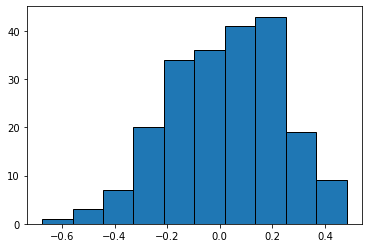

In [27]:
plt.hist(matchup_distance_gained['distance_gained'], ec='black')
plt.show()

In [28]:
# Merge player data
players_cleaned = players.copy()
players_cleaned.dropna(subset=['birthDate', 'height', 'weight'], inplace=True)
players_cleaned['age'] = players_cleaned['birthDate'].str.extract('(\d{4})')
players_cleaned['age'] = players_cleaned['age'].apply(lambda x: 2021 - int(x))

players_cleaned['height'] = players_cleaned['height'].apply(lambda x: int(x.split('-')[0]) + int(x.split('-')[1])/12)
player_matchup_progression = matchup_distance_gained.merge(players_cleaned)

player_matchup_progression = player_matchup_progression.merge(
    player_matchup_progression,
    left_on=['nflId2'],
    right_on=['nflId'],
    suffixes=('_defense', '_offense')
)

ml_data = player_matchup_progression[[
    'nflId_defense',
    'nflId_offense',
    'height_offense',
    'weight_offense',
    'age_offense',
    'height_defense',
    'weight_defense',
    'age_defense',
    'distance_gained_defense'
]]

In [29]:
y = ml_data['distance_gained_defense'].apply(lambda x: int(x > 0))
X = ml_data.drop(columns=['distance_gained_defense', 'nflId_defense', 'nflId_offense'])
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [30]:
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.5566502463054187


In [31]:
y = ml_data['distance_gained_defense'].apply(lambda x: int(x > 0))
X = ml_data.drop(columns=['distance_gained_defense'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [32]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train

,nflId_defense,nflId_offense,height_offense,weight_offense,age_offense,height_defense,weight_defense,age_defense
113,47796.0,47796.0,6.333333,315,26,6.333333,315,26
218,47975.0,47975.0,6.250000,295,25,6.250000,295,25
268,44813.0,44813.0,6.333333,272,26,6.333333,272,26
150,46197.0,46197.0,6.166667,287,25,6.166667,287,25
311,46264.0,46264.0,6.333333,310,26,6.333333,310,26
...,...,...,...,...,...,...,...,...
323,42375.0,42375.0,6.166667,320,27,6.166667,320,27
192,35485.0,35485.0,6.333333,329,33,6.333333,329,33
117,47796.0,47796.0,6.333333,315,26,6.333333,315,26
47,44829.0,44829.0,6.250000,300,26,6.250000,300,26


In [33]:
# Define the model - deep neural net
number_input_features = len(X_train.iloc[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=12, input_dim=number_input_features, activation="relu"))
nn.add(tf.keras.layers.Dense(units=12, activation="relu"))
nn.add(tf.keras.layers.Dense(units=12, activation="relu"))
nn.add(tf.keras.layers.Dense(units=12, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12)                108       
                                                                 
 dense_6 (Dense)             (None, 12)                156       
                                                                 
 dense_7 (Dense)             (None, 12)                156       
                                                                 
 dense_8 (Dense)             (None, 12)                156       
                                                                 
 dense_9 (Dense)             (None, 1)                 13        
                                                                 
Total params: 589
Trainable params: 589
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [37]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5785 - accuracy: 0.6711
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5792 - accuracy: 0.6875
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.6974
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5762 - accuracy: 0.6875
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5728 - accuracy: 0.7072
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5740 - accuracy: 0.6908
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5703 - accuracy: 0.6974
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.7072
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5708 - accuracy: 0.6941
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.5672 - accuracy: 0.6941


In [38]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

4/4 - 0s - loss: 0.7141 - accuracy: 0.5882 - 18ms/epoch - 5ms/step
Loss: 0.7140644192695618, Accuracy: 0.5882353186607361
